In [4]:
!pip install torch torchvision timm lime shap matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.7 MB/s eta 0:00:0000:0100:01


grey whale 0.873874306678772
tiger shark 0.007908593863248825
leatherback turtle 0.007705869618803263
great white shark 0.006708950735628605
dugong 0.002876007230952382


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


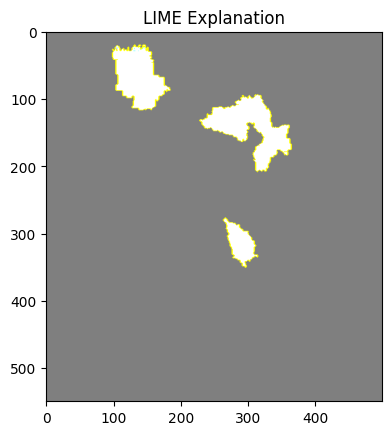

/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')
/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')
/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: GELU
  warnings.warn(f'unrecognized nn.Module: {module_type}')


AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 4.293602752022863 - Tolerance: 0.01

In [12]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import shap
import timm
from torchvision.models import ViT_B_16_Weights

# 加载预训练的ViT模型
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()

# 图像预处理
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 加载图像类别
categories = ViT_B_16_Weights.IMAGENET1K_V1.meta["categories"]

# 加载本地图像
image_path = 'n01491361/ILSVRC2012_val_00028564_n01491361.JPEG'
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)

# 模型预测
with torch.no_grad():
    output = model(input_tensor)
    
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

# 定义预测函数
def predict(images):
    if isinstance(images, np.ndarray):
        images = [Image.fromarray((img * 255).astype(np.uint8)) for img in images]
    batch = torch.stack(tuple(preprocess(i) for i in images), dim=0)
    predictions = model(batch)
    return predictions.detach().numpy()

# LIME解释
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(image), 
                                         predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

# 显示LIME结果
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation')
plt.show()

# SHAP解释
background = torch.zeros((1, 3, 224, 224))
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(input_tensor)

# 显示SHAP结果
shap.image_plot(shap_values, -input_tensor.cpu().numpy())
plt.title('SHAP Explanation')
plt.show()

In [11]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
import shap

# Load the pre-trained ViT model and feature extractor
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_name)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# Load your local image
img_path = 'n01491361/ILSVRC2012_val_00028564_n01491361.JPEG'  # Replace with your image path
image = Image.open(img_path).convert('RGB')

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    top_probs, top_labels = torch.topk(probs, 1)

# Print the top predicted label and probability
print(f"Predicted label: {top_labels[0].item()}, Probability: {top_probs[0].item()}")

# Function to preprocess images for LIME
def preprocess_fn(images):
    return feature_extractor(images=[Image.fromarray(image).convert('RGB') for image in images], return_tensors="pt").pixel_values.numpy()

# Function to predict using the model for LIME
def predict_fn(images):
    inputs = torch.tensor(images)
    with torch.no_grad():
        outputs = model(pixel_values=inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).numpy()
    return probs

# LIME explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(image), predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Plot LIME explanation
temp, mask = explanation.get_image_and_mask(top_labels[0].item(), positive_only=True, num_features=10, hide_rest=False)
plt.imshow(temp)
plt.title('LIME Explanation')
plt.show()

# SHAP explanation
def shap_predict(images):
    inputs = torch.tensor(images).to(model.device)
    with torch.no_grad():
        outputs = model(pixel_values=inputs)
    return outputs.logits

background = torch.cat([feature_extractor(images=image, return_tensors="pt").pixel_values for _ in range(50)], dim=0).numpy()
e = shap.DeepExplainer(shap_predict, background)
shap_values = e.shap_values(feature_extractor(images=image, return_tensors="pt").pixel_values.numpy())

# Plot SHAP explanation
shap.image_plot(shap_values, np.array([image]))


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted label: 1, Probability: 0.5460480451583862


  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Make sure that the channel dimension of the pixel values match with the one set in the configuration. Expected 3 but got 550.